In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
from scipy.stats import binned_statistic, binned_statistic_dd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/queenle/ml_env_v2/share/proj failed


In [2]:
# directories

hist_counts_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/compute_metrics/results/histogram_counts'
psd_counts_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/compute_metrics/results/PSD_counts'

plot_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/plots/dist_errors'
final_figure_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/final_figures'


# Standard Variables

lims = {'rx1d':(0,11),'top_200':(0,7.5)}

colors = {'GAN':'blue','unet':'orange'}
capitalized = {'GAN':'GAN','unet':'U-Net','rx1d':'Rx1d','annual_mean':'Annual Mean','DJF_mean':'DJF Mean','JJA_mean':'JJA Mean',\
               'perfect':'Perfect','imperfect':'Imperfect'}

x_ticks = {'1961-1980':160,'2015-2034':170,'2080-2099':180}

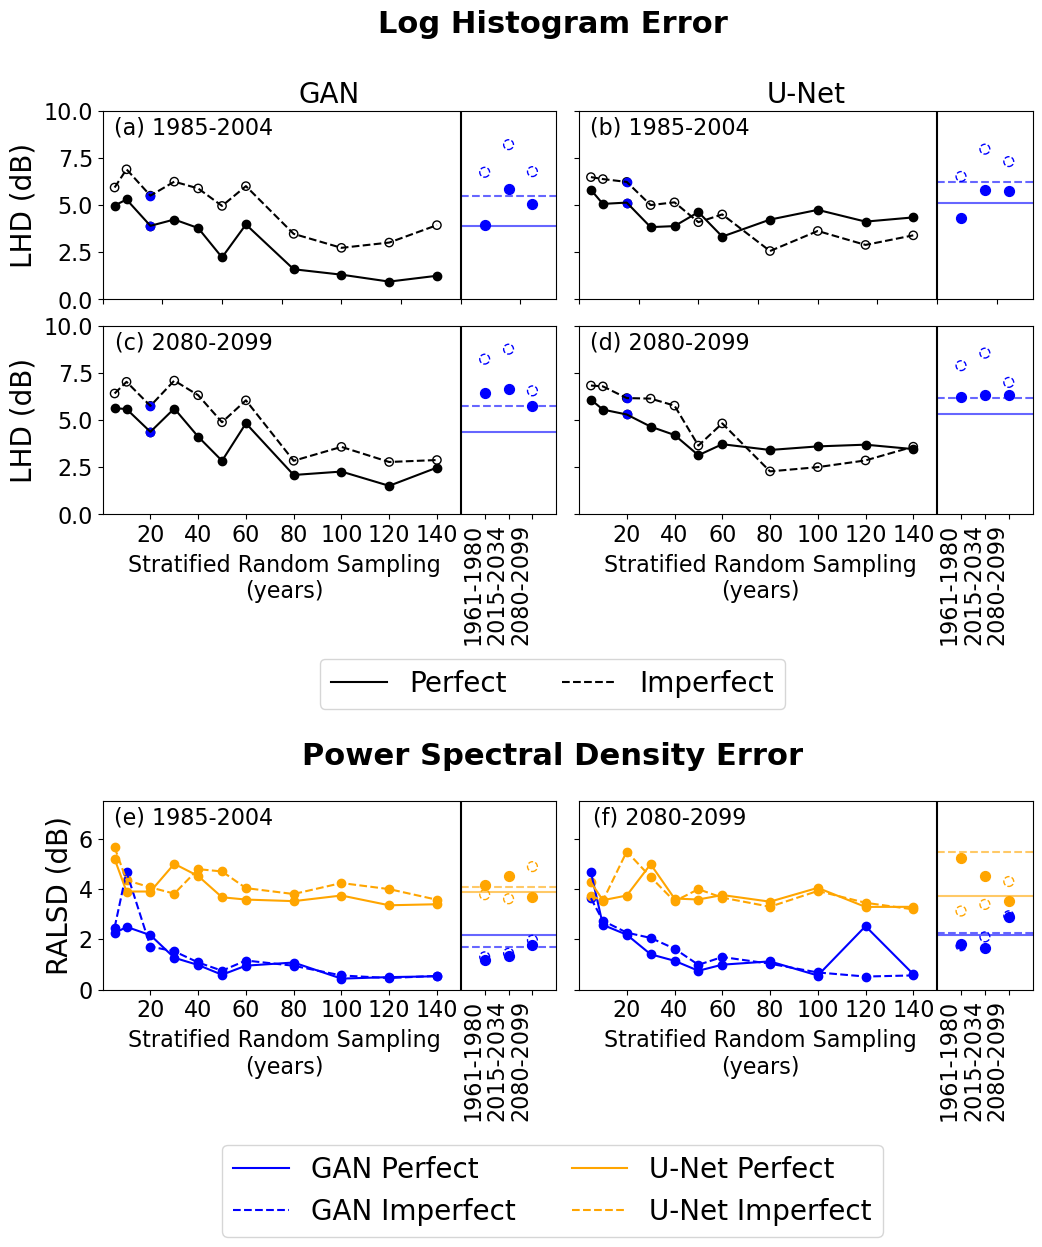

In [10]:
'''

Produce final Figure 5 - LHD and RALSD of top 200 rainiest days averaging over 2 GCMs (EC-Earth3,NorESM2-MM) and 3 epochs (220,225,230)

'''

metric = 'top_200'
epochs = ['220','225','230']
gcms = ['EC-Earth3','NorESM2-MM']

fig, axs, title_artist = create_figure()

plot_LHD(fig,[axs[0],axs[1]],epochs,gcms,subplot_labels = [['(a)','(b)'],['(c)','(d)']])
legend = plot_RALSD(fig,axs[2],epochs,gcms,metric,subplot_labels = ['(e)','(f)'])

plt.savefig(f'{final_figure_dir}/Figure5.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,title_artist))
#plt.close()

In [15]:
'''

Produce plots across all dimensions - metric, GCM, epoch - including 2-GCM and 3-epoch average

'''

for metric in ['top_200','rx1d']:
    
    for gcms in [['EC-Earth3'],['NorESM2-MM'],['EC-Earth3','NorESM2-MM']]:

        for epochs in [['220'],['225'],['230'],['220','225','230']]:

            fig, axs, title_artist = create_figure()

            plot_LHD(fig,[axs[0],axs[1]],epochs,gcms,subplot_labels = [['(a)','(b)'],['(c)','(d)']])
            legend = plot_RALSD(fig,axs[2],epochs,gcms,subplot_labels = ['(e)','(f)'],metric)

            gcm_string = '-'.join(gcms)
            epoch_string = '-'.join(epochs)
            plt.savefig(f'{plot_dir}/{metric}_LHD_RALSD_{gcm_string}_epoch_{epoch_string}.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,title_artist))
            plt.close()

In [4]:
'''
CREATE FIGURE function
'''

def create_figure():
    fig = plt.figure(figsize=(12, 12))

    # Grid layout: 5 rows for finer control
    # Rows: [Row 1], [Row 2], [Legend 1], [Spacer], [Row 3], [Legend 2]
    gs = gridspec.GridSpec(6, 2, 
                           height_ratios=[1, 1, 0.1, 1, 1, 0.1], 
                           hspace=0.2, 
                           wspace=0.05)

    # Plot axes
    ax00 = fig.add_subplot(gs[0, 0])
    ax01 = fig.add_subplot(gs[0, 1])
    ax10 = fig.add_subplot(gs[1, 0])
    ax11 = fig.add_subplot(gs[1, 1])
    ax20 = fig.add_subplot(gs[4, 0])
    ax21 = fig.add_subplot(gs[4, 1])
    
    title_artist = fig.text(0.5, 0.94,"Log Histogram Error",ha='center', va='bottom',fontsize=22, fontweight='bold')
    fig.text(0.5, 0.33, "Power Spectral Density Error", ha='center', va='bottom', fontsize=22, fontweight='bold')
    

    return fig, [[ax00, ax01], [ax10, ax11], [ax20, ax21]], title_artist




In [5]:
'''
LHD Functions
'''

def get_lhd_db(h1, h2, eps=1e-12):
    h1 = np.asarray(h1)
    h2 = np.asarray(h2)
    assert h1.shape == h2.shape, "Histograms must have the same shape"
    
    mask = (h1 >= 10) & (h2 >= 10)
    h1 = h1[mask]
    h2 = h2[mask]

    log_diff_dB = 10 * (np.log10(h1) - np.log10(h2))
    lhd_db = np.sqrt(np.mean(log_diff_dB ** 2))
    
    return lhd_db

def write_lhd_to_dict(result_dict,period,epoch,gcm,ml_type,framework,n,lhd_db):
    
    result_dict['period'].append(period)
    result_dict['epoch'].append(epoch)
    result_dict['GCM'].append(gcm)
    result_dict['ml_type'].append(ml_type)
    result_dict['framework'].append(framework)
    result_dict['sample_n'].append(n)
    result_dict['lhd_db'].append(lhd_db)
    
    
bins = np.arange(1, 1051, 20)

def get_lhd_df(start,end,epochs):
    
    result_dict = {'GCM':[],'ml_type':[],'framework':[],'period':[],'sample_n':[],'lhd_db':[],'epoch':[]}

    for epoch in epochs:
        for gcm in ['EC-Earth3','NorESM2-MM']:
            for ml_type in ['GAN','unet']:
                for framework in ['perfect','imperfect']:

                    df = pd.read_csv(f'{hist_counts_dir}/{gcm}_{ml_type}_{framework}_epoch_{epoch}_{start}-{end}_histogram_counts.csv').drop('Unnamed: 0',axis=1)

                    ccam_counts = df['CCAM']

                    for i,n in enumerate(['5','10','20','30','40','50','60','80','100','120','140','1961-1980','2015-2034','2080-2099']):

                        ml_counts = df[n]

                        lhd_db = get_lhd_db(ml_counts,ccam_counts)

                        write_lhd_to_dict(result_dict,f'{start}-{end}',epoch,gcm,ml_type,framework,n,lhd_db)

    df = pd.DataFrame.from_dict(result_dict)
    
    return(df)

    
def plot_LHD(fig,axs,epochs,gcms,subplot_labels):
    
    for i,period in enumerate([('1985','2004'),('2080','2099')]):

        start,end = period[0],period[1]

        df = get_lhd_df(start,end,epochs)

        for j,ml_type in enumerate(['GAN','unet']):

            ml_type_df = df[df['ml_type']==ml_type]

            for framework in ['perfect','imperfect']:

                framework_df = ml_type_df[ml_type_df['framework']==framework]

                gcm_dfs = []
                for gcm  in gcms:
                    gcm_result = framework_df[framework_df['GCM']==gcm].groupby('sample_n').mean(numeric_only=True)['lhd_db']
                    gcm_dfs.append(gcm_result)

                mean = sum(gcm_dfs)/len(gcm_dfs)

                results_n = mean[~mean.index.isin(['1961-1980','2015-2034','2080-2099'])]
                results_n.index = results_n.index.astype(int)
                results_n = results_n.sort_index()

                results_20 = mean[mean.index.isin(['1961-1980','2015-2034','2080-2099'])]

                # PLOTTING

                # dashed line at 20-year random sampling
                random_20_val = results_n[20]
                #axs[i][j].hlines(random_20_val,15,25,color='red',linestyle='-' if framework=='perfect' else '--',alpha=0.6)
                axs[i][j].hlines(random_20_val,150,190,color='blue',linestyle='-' if framework=='perfect' else '--',alpha=0.6)#,label=f'{ml_type} random 20-year sample')

                # n samples
                x = [int(v) for v in results_n.index]
                axs[i][j].scatter(x,results_n,facecolors='none' if framework=='imperfect' else 'black',edgecolors='black')
                axs[i][j].plot(x,results_n,color='black',linestyle = '-' if framework=='perfect' else '--',label=f'{capitalized[framework]}')
                axs[i][j].scatter(20,random_20_val,color='blue')

                # 20-year samples
                for k,index in enumerate(results_20.index):
                    x_val = x_ticks[index]
                    axs[i][j].scatter(x_val,results_20.loc[index],s=50,facecolors='none' if framework=='imperfect' else 'blue',edgecolors='blue',linestyle = '-' if framework=='perfect' else '--')

            if i == 0:
                axs[i][j].set_title(capitalized[ml_type],fontsize=20)
                axs[i][j].set_xticklabels([])
                
            else:
                axs[i][j].text(0.4, -0.34, 'Stratified Random Sampling\n(years)', va='center', ha='center',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=16)

                # configure xticks and labels
                positions = [20, 40, 60, 80, 100, 120, 140, 160, 170, 180]
                labels = ['20', '40', '60', '80', '100', '120', '140', '1961-1980', '2015-2034', '2080-2099']

                # Set all at once
                axs[i][j].set_xticks(positions)
                axs[i][j].set_xticklabels(labels, fontsize=16)
                
                # Rotate only the "future period" labels
                for pos, label in zip(positions, axs[i][j].get_xticklabels()):
                    if pos >= 160:
                        label.set_rotation(90)
                        label.set_ha('right')

            axs[i][j].text(0.2,0.85,f'{subplot_labels[i][j]} {start}-{end}', transform=axs[i][j].transAxes,ha='center', va='bottom', fontsize=16)

            # AXIS LABELS
            axs[i][j].set_ylim(0,10)
            if j == 0:
                axs[i][j].set_ylabel('LHD (dB)',fontsize=20)
            else:
                axs[i][j].set_yticklabels([])

            axs[i][j].axvline([150],color='black')
            axs[i][j].tick_params(axis='y', labelsize=16)
            axs[i][j].set_xlim(0,190)


    # Legend handles (assume same for all)
    handles, labels = axs[0][1].get_legend_handles_labels()

    # Legend below second row
    fig.legend(handles, labels,
               loc='lower center',
               bbox_to_anchor=(0.5, 0.37),  # between row 2 and row 3
               ncol=2,
               frameon=True,
               fontsize=20)

In [9]:
'''
RALSD Functions
'''

def write_ralsd_to_dict(result_dict,period,epoch,gcm,ml_type,framework,n,ralsd):
    
    result_dict['period'].append(period)
    result_dict['epoch'].append(epoch)
    result_dict['GCM'].append(gcm)
    result_dict['ml_type'].append(ml_type)
    result_dict['framework'].append(framework)
    result_dict['sample_n'].append(n)
    result_dict['ralsd'].append(ralsd)
    
    
def get_ralsd_df(start,end,metric,epochs):
    
    result_dict = {'GCM':[],'ml_type':[],'framework':[],'period':[],'sample_n':[],'ralsd':[],'epoch':[]}

    for epoch in epochs:
        for gcm in ['EC-Earth3','NorESM2-MM']:
            for ml_type in ['GAN','unet']:
                for framework in ['perfect','imperfect']:
            
                    df = pd.read_csv(f'{psd_counts_dir}/{gcm}_{ml_type}_{framework}_epoch_{epoch}_{start}-{end}_{metric}_PSD_counts.csv').drop('Unnamed: 0',axis=1)

                    ccam_counts = df['CCAM']

                    for i,n in enumerate(['5','10','20','30','40','50','60','80','100','120','140','1961-1980','2015-2034','2080-2099']):#,'140'

                        ml_counts = df[n]
                        
                        log_diff = 10 * (np.log10(ml_counts) - np.log10(ccam_counts))
                        diff_rmse = np.sqrt(np.mean(log_diff ** 2))

                        write_ralsd_to_dict(result_dict,f'{start}-{end}',epoch,gcm,ml_type,framework,n,diff_rmse)

    df = pd.DataFrame.from_dict(result_dict)
    
    return(df)

def plot_RALSD(fig,axs,epochs,gcms,metric,subplot_labels):
    
    low,high = lims[metric]
    
    for i,period in enumerate([('1985','2004'),('2080','2099')]):

        start,end = period[0],period[1]

        df = get_ralsd_df(start,end,metric,epochs)

        for ml_type in ['GAN','unet']:

            ml_type_df = df[df['ml_type']==ml_type]

            for framework in ['perfect','imperfect']:

                framework_df = ml_type_df[ml_type_df['framework']==framework]

                gcm_dfs = []
                for gcm  in gcms:
                    gcm_result = framework_df[framework_df['GCM']==gcm].groupby('sample_n').mean(numeric_only=True)['ralsd']
                    gcm_dfs.append(gcm_result)

                mean = sum(gcm_dfs)/len(gcm_dfs)

                results_n = mean[~mean.index.isin(['1961-1980','2015-2034','2080-2099'])]
                results_n.index = results_n.index.astype(int)
                results_n = results_n.sort_index()

                results_20 = mean[mean.index.isin(['1961-1980','2015-2034','2080-2099'])]

                # PLOTTING

                # dashed line at 20-year random sampling
                random_20_val = results_n[20]
                #axs[i].hlines(random_20_val,15,25,color=colors[ml_type],alpha=0.6,linestyle = '-' if framework=='perfect' else '--')
                axs[i].hlines(random_20_val,150,190,color=colors[ml_type],alpha=0.6,linestyle = '-' if framework=='perfect' else '--')

                # n samples
                x = [int(v) for v in results_n.index]
                axs[i].plot(x,results_n,color=colors[ml_type],linestyle = '-' if framework=='perfect' else '--',label=f'{capitalized[ml_type]} {capitalized[framework]}')
                axs[i].scatter(x,results_n,color=colors[ml_type])

                # 20-year samples
                for k,index in enumerate(results_20.index):
                    x_val = x_ticks[index]
                    axs[i].scatter(x_val,results_20.loc[index],s=50,facecolors='none' if framework == 'imperfect' else colors[ml_type],edgecolors=colors[ml_type],linestyle = '-' if framework=='perfect' else '--')

        axs[i].text(0.2,0.85,f'{subplot_labels[i]} {start}-{end}', transform=axs[i].transAxes,ha='center', va='bottom', fontsize=16)

        # AXIS LABELS
        axs[i].set_ylim(low,high)

        axs[i].text(0.4, -0.34, 'Stratified Random Sampling\n(years)', va='center', ha='center',rotation='horizontal', transform=axs[i].transAxes,fontsize=16)


        axs[i].axvline([150],color='black')
        axs[i].tick_params(axis='y', labelsize=16)
        axs[i].set_xlim(0,190)

        if i == 0:
            axs[i].set_ylabel('RALSD (dB)',fontsize=20)
        else:
            axs[i].set_yticklabels([])

        # configure xticks and labels
        positions = [20, 40, 60, 80, 100, 120, 140, 160, 170, 180]
        labels = ['20', '40', '60', '80', '100', '120', '140', '1961-1980', '2015-2034', '2080-2099']

        # Set all at once
        axs[i].set_xticks(positions)
        axs[i].set_xticklabels(labels, fontsize=16)

        # Rotate only the "future period" labels
        for pos, label in zip(positions, axs[i].get_xticklabels()):
            if pos >= 160:
                label.set_rotation(90)
                label.set_ha('right')


    handles, labels = axs[0].get_legend_handles_labels()

    # Legend below third row
    legend = fig.legend(handles, labels,
               loc='lower center',
               bbox_to_anchor=(0.5, -0.07),  # bottom of figure
               ncol=2,
               frameon=True,
               fontsize=20)
    
    return(legend)
